In [1]:
import os
import pandas as pd
import scipy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### Import csv

In [2]:
df = pd.read_csv("argus_info_output_fluidics.csv")
df['added'] = False

In [3]:
df.head()

,timestamp,layer,parent,has_doughter,duration,incubation_duration,type,end_flag,extended_description,doughter_duration,execution_time,added
0,2022-11-22 17:27:43.648,0,NaN,True,150.585,60.0,HURWellExchange,end,"{'selected_wells': [{'carrier_id': 'unit0', 's...",89.874,0.711,False
1,2022-11-22 17:27:44.267,1,0.0,True,84.486,0.0,HURDispense,end,"{'selected_wells': [{'carrier_id': 'unit0', 's...",84.356,0.130,False
2,2022-11-22 17:27:44.271,2,1.0,True,30.778,0.0,WellExtract,end,"{'selected_wells': [{'carrier_id': 'unit0', 's...",25.074,5.704,False
3,2022-11-22 17:27:44.378,3,2.0,True,2.574,0.0,SetADPZToSafeTravelHeight,end,{'entry_criteria': [<argus.fluidics.cs1.fl_adp...,2.567,0.007,False
4,2022-11-22 17:27:44.382,4,3.0,False,2.567,0.0,SetADPZPosition,end,"{'z_target_nm': 100000, 'acceleration_nmps': 1...",0.000,2.567,False


### Populate nested dictionary with times and subtasks of each higher level device task

In [4]:
# A recursive function to record and notate the lineage and times of a nested step within a fluidics step
# Makes a new dict layer if it does not exist and populates with the data being passed to it

def add_layer_to_dict(current_dict, lineage_array, lineage_time, lineage_added, lineage_sum_time):
    # Pop from the first index position of dictionary to recusively ingest the entire data file
    current_layer = lineage_array.pop(0)
    current_time = lineage_time.pop(0)
    current_added = lineage_added.pop(0)
    current_sum_time = lineage_sum_time.pop(0)
    
    # Check if step exists at the current nested layer of the dictionary
    # Append information if exists
    if current_dict.get(current_layer) != None:
        # Check if the specific row has already been added to the dictionary
        if current_added == False:
            current_dict[current_layer]['times'].append(current_time)
            current_dict[current_layer]['sum_times'].append(current_sum_time)
            
    # If not, create that layer and append information
    else:
        current_dict[current_layer] = {'times': [], 'sum_times': [], 'substeps': {}}
        current_dict[current_layer]['times'].append(current_time)
        current_dict[current_layer]['sum_times'].append(current_sum_time)
        
    # While there are still layers in the dictionary, call the function again with the next layer down in the dict
    if len(lineage_array) > 0:
        add_layer_to_dict(current_dict[current_layer]['substeps'], lineage_array, lineage_time, lineage_added, lineage_sum_time)
    else:
        return

In [5]:
# Create empty dict
top_level = {}

# Iterate through main dataframe
for i, row in enumerate(df.iterrows()):
    row = row[1]
    layer = row['layer']
            
    # Check if the current row is the end of a device task chain
    if row['has_doughter'] == False:
        step_type = row['type']
        layer = row['layer']
        lineage_array = []
        lineage_time = []
        lineage_sum_time = []
        lineage_added = []
        lineage_array.append(row['type'])
        lineage_time.append(row['execution_time'])
        lineage_sum_time.append(row['duration'] - row['incubation_duration'])
        lineage_added.append(row['added'])
        df.iloc[[i],[11]] = True
        parent_row_iloc = int(row['parent'])
        
        # Ascend back up the device task chain until you rach the top level task
        while layer != 0:
            parent_type = df.iloc[parent_row_iloc]['type']
            layer = df.iloc[parent_row_iloc]['layer']
            exec_time = df.iloc[parent_row_iloc]['execution_time']
            daughter_time = df.iloc[parent_row_iloc]['duration'] - df.iloc[parent_row_iloc]['incubation_duration']
            added_state = df.iloc[parent_row_iloc]['added']
            df.iloc[[parent_row_iloc],[11]] = True
            try:
                parent_row_iloc = int(df.iloc[parent_row_iloc]['parent'])
            except ValueError:
                pass #Reached a NaN from top layer
            lineage_array.insert(0, parent_type)
            lineage_time.insert(0, exec_time)
            lineage_added.insert(0, added_state)
            lineage_sum_time.insert(0, daughter_time)
        
        # Add the device task stack to the dictionary
        add_layer_to_dict(top_level, lineage_array, lineage_time, lineage_added, lineage_sum_time)
        
top_level_nested = {'times': [0], 'sum_times': [0], 'substeps': top_level}
# Reset the dataframe column to false to allow the block to be rerun without error
df['added'] = False

In [6]:
# Function to determin statistics for each layer of the nested dictionary
def nested_dict_pairs_iterator(current_dict):
    try:
        current_dict['stats'] = []
    except TypeError:
#         print("hit the type error")
        return
    
    keys = current_dict.keys()
    
    # Check if the current layer contains a substepd dict. If not, it is the top level and must be treated differently
    if 'substeps' in keys:
        current_dict['stats'].append(np.mean(current_dict['times'])) # step time mean
        current_dict['stats'].append(np.std(current_dict['times'])) # step time std
        current_dict['stats'].append(np.mean(current_dict['sum_times'])) # aggregate time mean
        current_dict['stats'].append(np.std(current_dict['sum_times'])) # aggregate time std
        current_dict['stats'].append(len(current_dict['times'])) # Number of times completed in run

        keys = current_dict['substeps'].keys()
    
        if keys:
            for key in keys:
                nested_dict_pairs_iterator(current_dict['substeps'][key])
        else:
            return
    else:
        if keys:
            for key in keys:
                nested_dict_pairs_iterator(current_dict[key])
        else:
            return
        
# Call function on top_level dict
nested_dict_pairs_iterator(top_level)
nested_dict_pairs_iterator(top_level_nested)
del top_level_nested['substeps']['stats']

### Plotting

In [39]:
# Function to plot the high level historgram of the top layer of the dictionary
# as well as a scatter plot with error bars of the next layer of subtasks
# which comprise the top layer task

def plot_times(plot_dict, title=''):
    mean_times = []
    std_times = []
    mean_sum_times = []
    std_sum_times = []
    num_times = []
    steps = []

    for key in list(plot_dict['substeps'].keys()):
        stats = plot_dict['substeps'][key]['stats']
        steps.append(key)
        mean_times.append(stats[0])
        std_times.append(1.96*stats[1])
        mean_sum_times.append(stats[2])
        std_sum_times.append(1.96*stats[3])
        num_times.append(stats[4])
        
        
    if plot_dict['stats'][0] > 1:
        steps.append('wait_s')
        mean_times.append(plot_dict['stats'][0])
        std_times.append(plot_dict['stats'][1])
        mean_sum_times.append(plot_dict['stats'][0])
        std_sum_times.append(plot_dict['stats'][1])
        num_times.append(plot_dict['stats'][4])

    print(plot_dict['stats'])
    print(list(zip(steps, num_times)))

    fig, ax = plt.subplots(figsize=(10,6))
    ax.hist(plot_dict['sum_times'])
    ax.set(title='Timing Distributions for {}'.format(title))
    plt.show()

    fig, ax = plt.subplots(figsize=(10,6))
    ax.scatter(steps, mean_sum_times)
    ax.set(title='Average substep times and distribution for {}'.format(title), 
          xlabel='Substep', ylabel='Time (s)')
    bottom, top = plt.ylim()
    offset = top*0.05
    for index in range(len(steps)):
          ax.text(steps[index], mean_sum_times[index]+offset, 
                  "{} times, \n{:.0f} mins, \n{:.2f} s_per"
                  .format(num_times[index], (num_times[index] * mean_sum_times[index])/60, mean_sum_times[index]), size=12)
    plt.errorbar(steps,mean_sum_times,yerr=std_sum_times, linestyle="None")
    plt.xticks(rotation = 45)
    plt.show()

### Plotting Scratch

[2.995062500000002, 1.1449498880273128, 156.366515625, 68.997493795063, 64]
[('LoadADPTip', 60), ('LURAspirate', 94), ('MachineVisionCorrection', 94), ('WellExtract', 94), ('LURDispenseAspiratedReagent', 94), ('EjectADPTip', 60), ('AlignADPToTipTray', 34), ('wait_s', 64)]


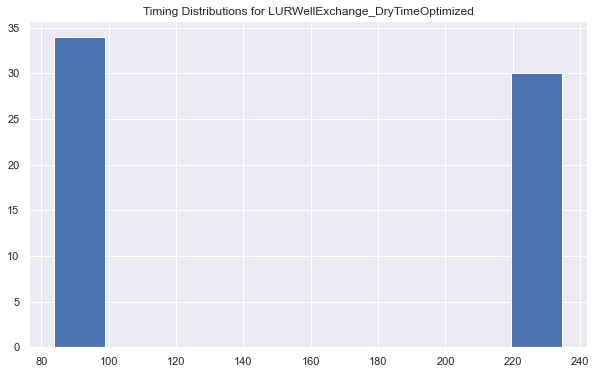

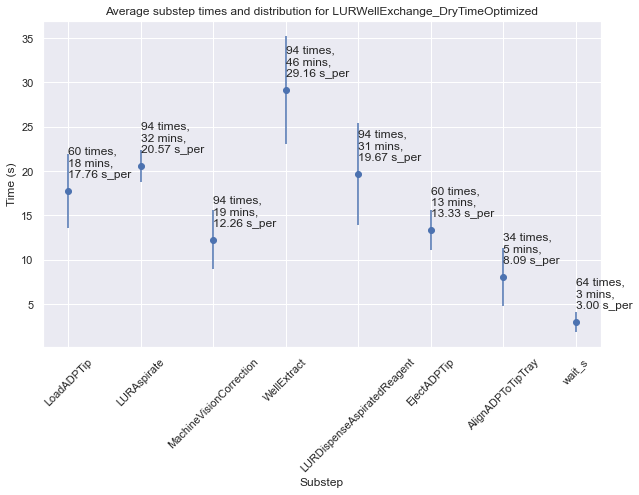

In [40]:
plot_dict = top_level['LURWellExchange_DryTimeOptimized']
plot_times(plot_dict, 'LURWellExchange_DryTimeOptimized')

[4.222765957446809, 0.7272799722184303, 12.258106382978722, 1.70683633853835, 94]
[('AlignADPToMachineVisionPosition', 94), ('wait_s', 94)]


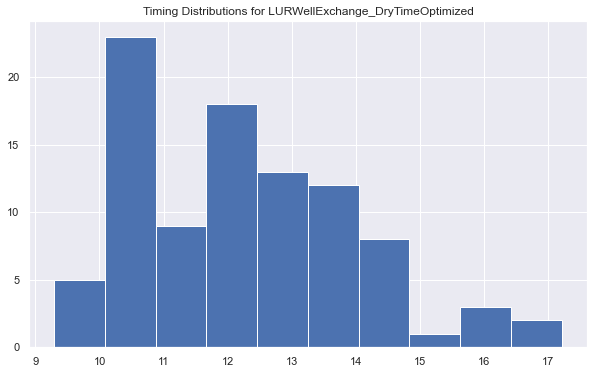

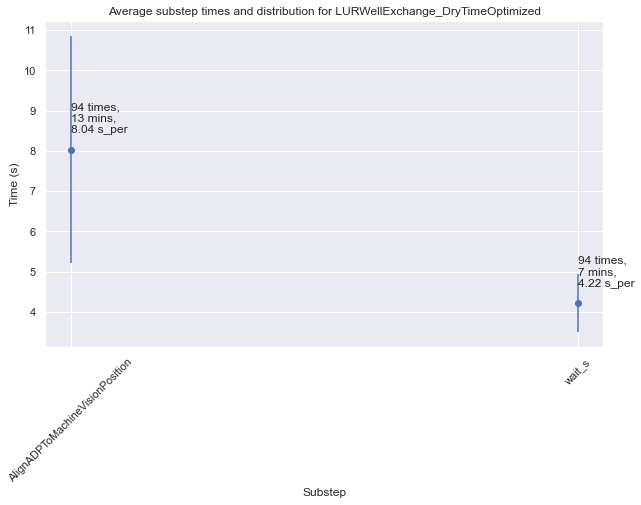

In [43]:
plot_dict = top_level['LURWellExchange_DryTimeOptimized']['substeps']['MachineVisionCorrection']
plot_times(plot_dict, 'LURWellExchange_DryTimeOptimized')

[15.69067021276596, 3.1747656116810767, 19.66672340425532, 2.914611785412425, 94]
[('AlignADPToWell', 94), ('wait_s', 94)]


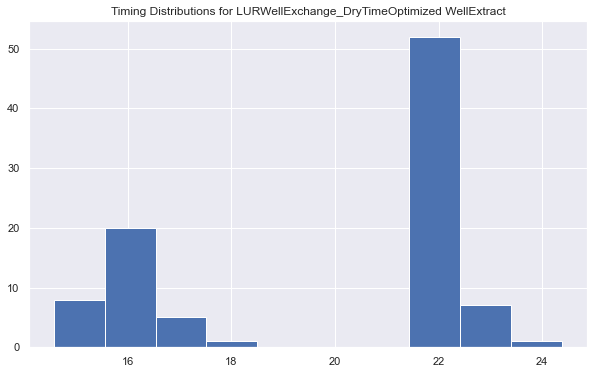

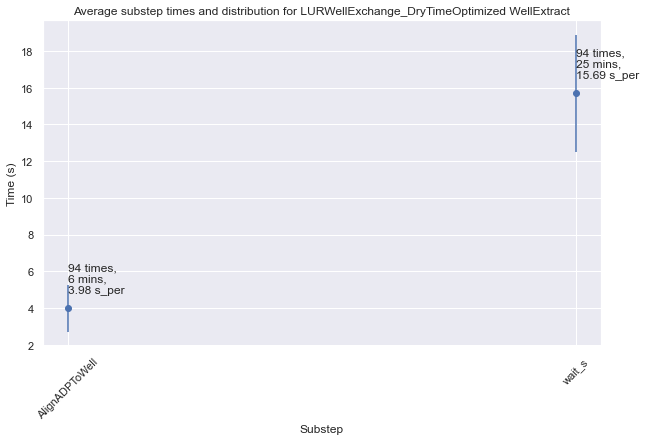

In [42]:
plot_dict = top_level['LURWellExchange_DryTimeOptimized']['substeps']['LURDispenseAspiratedReagent']
plot_times(plot_dict, 'LURWellExchange_DryTimeOptimized WellExtract')

[6.285010638297872, 0.7687336712630947, 29.157340425531906, 3.124924075854506, 94]
[('SetADPZToSafeTravelHeight', 188), ('StartPeristalticPump', 94), ('AlignSipperTubeToWellExtractLocation', 188), ('MachineVisionCorrection', 94), ('SetSipperZToSafeTravelHeight', 188), ('StopPeristalticPump', 94), ('wait_s', 94)]


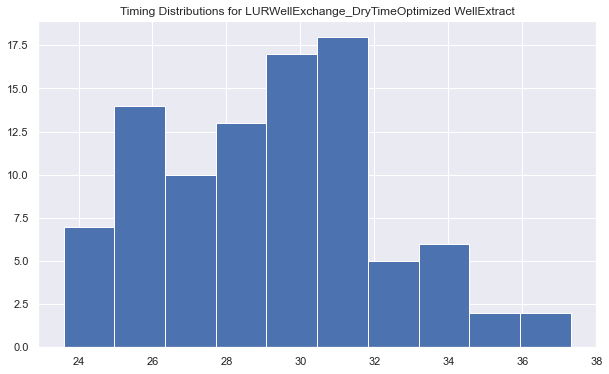

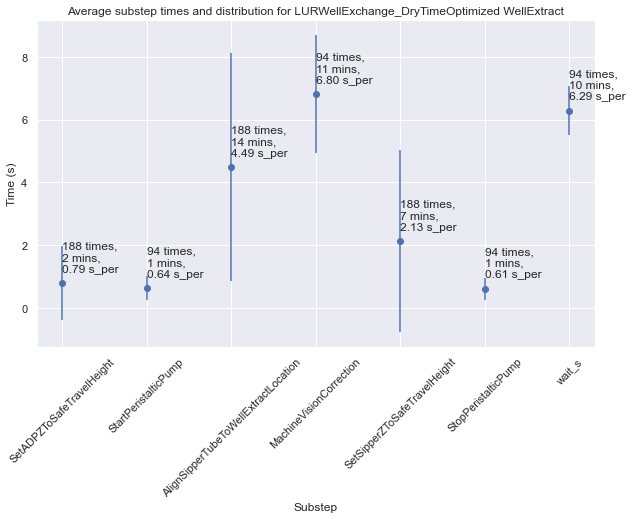

In [41]:
plot_dict = top_level['LURWellExchange_DryTimeOptimized']['substeps']['WellExtract']
plot_times(plot_dict, 'LURWellExchange_DryTimeOptimized WellExtract')

[15.69067021276596, 3.1747656116810767, 19.66672340425532, 2.914611785412425, 94]
['AlignADPToWell', 'wait_s']
[('AlignADPToWell', 94), ('wait_s', 94)]


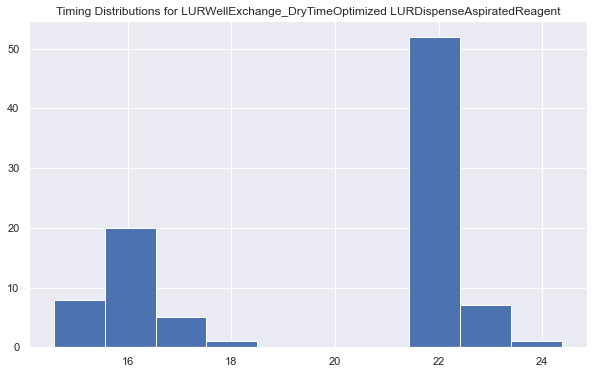

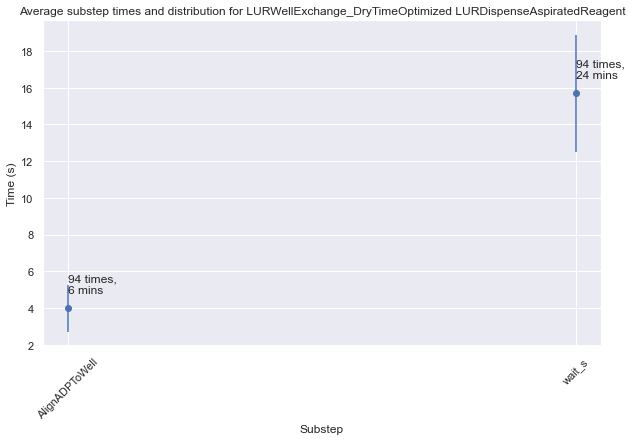

In [17]:
plot_dict = top_level['LURWellExchange_DryTimeOptimized']['substeps']['LURDispenseAspiratedReagent']
plot_times(plot_dict, 'LURWellExchange_DryTimeOptimized LURDispenseAspiratedReagent')